In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from sklearn.metrics import mean_squared_error

# Procesamiento de Datos 

In [4]:
datos = pd.read_excel(io='data/datos.xlsx', sheet_name = "Hoja1")
datos

,AÑO,MES,DIA,FECHA,HORA,Caudal
0,2015,1,1,jueves,00:00:00,1100.7567
1,2015,1,1,jueves,00:30:00,1100.7567
2,2015,1,1,jueves,01:00:00,1100.7567
3,2015,1,1,jueves,01:30:00,742.7767
4,2015,1,1,jueves,02:00:00,742.7767
...,...,...,...,...,...,...
81784,2019,12,31,martes,21:30:00,909.7567
81785,2019,12,31,martes,22:00:00,909.7567
81786,2019,12,31,martes,22:30:00,909.7567
81787,2019,12,31,martes,23:00:00,909.7567


## Verificación de valores nulos

In [5]:
datos.isnull().sum()

AÑO       0
MES       0
DIA       0
FECHA     0
HORA      0
Caudal    0
dtype: int64

## Fecha como índice

In [6]:
from datetime import datetime 
datos_indexados = pd.DataFrame()
fechas_dt = []
caudal_dt = []
for registro in datos.values:
    fecha = "{}-{}-{} {}".format(registro[0], registro[1], registro[2], registro[4])
    fecha_dt = datetime.strptime(fecha, '%Y-%m-%d %H:%M:%S')
    fechas_dt.append(fecha_dt)
    caudal_dt.append(registro[5])
datos_indexados['FECHA'] = fechas_dt
datos_indexados['CAUDAL'] = caudal_dt

datos_indexados.set_index('FECHA', drop=True, inplace = True)

datos_indexados

,CAUDAL
FECHA,
2015-01-01 00:00:00,1100.7567
2015-01-01 00:30:00,1100.7567
2015-01-01 01:00:00,1100.7567
2015-01-01 01:30:00,742.7767
2015-01-01 02:00:00,742.7767
...,...
2019-12-31 21:30:00,909.7567
2019-12-31 22:00:00,909.7567
2019-12-31 22:30:00,909.7567


# División de los Datos 

In [7]:
division = int(0.2*datos_indexados.shape[0])
fecha_fin_train = '2019-04-01 00:00:00'
datos_train = datos_indexados[:datos_indexados.index.get_loc(fecha_fin_train)[0]]
datos_test = datos_indexados[datos_indexados.index.get_loc(fecha_fin_train)[0]:]
datos_train


,CAUDAL
FECHA,
2015-01-01 00:00:00,1100.7567
2015-01-01 00:30:00,1100.7567
2015-01-01 01:00:00,1100.7567
2015-01-01 01:30:00,742.7767
2015-01-01 02:00:00,742.7767
...,...
2019-03-31 21:30:00,711.1067
2019-03-31 22:00:00,711.1067
2019-03-31 22:30:00,711.1067


In [8]:
datos_test

,CAUDAL
FECHA,
2019-04-01 00:00:00,711.1067
2019-04-01 00:30:00,711.1067
2019-04-01 01:00:00,711.1067
2019-04-01 01:30:00,711.1067
2019-04-01 02:00:00,711.1067
...,...
2019-12-31 21:30:00,909.7567
2019-12-31 22:00:00,909.7567
2019-12-31 22:30:00,909.7567


## Transformación de datos a numérica (CONFIRM)

In [9]:
# (data_train[0:1].values)

## Normalización de los datos 

In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
datos_train_scaled = sc.fit_transform(datos_train)
print(datos_train_scaled.shape)
datos_train_scaled

(68589, 1)


array([[0.70148996],
       [0.70148996],
       [0.70148996],
       ...,
       [0.49749754],
       [0.49749754],
       [0.49749754]])

## Agrupamiento de los datos 

In [11]:
time_step = 70 
X_train = [] 
Y_train = []
m = len(datos_train_scaled)
for i in range(time_step, m):
    X_train.append(datos_train_scaled[i-time_step:i, 0]) 
    Y_train.append(datos_train_scaled[i, 0]) 
X_train, Y_train = np.array(X_train), np.array(Y_train) 
X_train.shape, Y_train.shape 

((68519, 70), (68519,))

## Reshape de los Datos 

In [12]:
#Buscamos un array de 3 dimensiones
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
X_train.shape, Y_train.shape

((68519, 70, 1), (68519,))

# LSTM y Train

In [13]:
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

In [14]:
def MODEL_LSTM(optimizador, neuronas, epocas):
    dim_entrada = (X_train.shape[1],X_train.shape[2])
    dim_salida = 1 
    num_neuronas = neuronas
    model = Sequential()
    model.add(LSTM(units=num_neuronas, return_sequences = True, input_shape=dim_entrada))
    model.add(Dropout(0.4))
    model.add(LSTM(units=num_neuronas))
    model.add(Dropout(0.2))
    model.add(Dense(units = dim_salida))
    model.compile(optimizer= optimizador, loss='mse', metrics = ['mean_absolute_error']) #mean_squared_error
    history = model.fit(X_train, Y_train, epochs = epocas, batch_size = 64)
    return model, history

In [15]:
def predecirDataTest(modelo):
    x_test  = datos_test.values
    x_test = sc.transform(x_test)
    X_test = []
    for i in range(time_step, len(x_test)):
        X_test.append(x_test[i-time_step: i, 0])
    X_test= np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    X_test.shape
    prediccion = modelo.predict(X_test)
    prediccion = sc.inverse_transform(prediccion)
    return prediccion

## Ejecución del modelo 

In [ ]:
model, history = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 10, epocas = 10)
#Guardamos el modelo para no tener que entrenar otra vez para probar
model.save('modelos/model.h5')

Epoch 1/10
1071/1071 [==============================] - 72s 63ms/step - loss: 0.0139 - mean_absolute_error: 0.0842
Epoch 2/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0040 - mean_absolute_error: 0.0443
Epoch 3/10
1071/1071 [==============================] - 67s 62ms/step - loss: 0.0029 - mean_absolute_error: 0.0363
Epoch 4/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.0027 - mean_absolute_error: 0.0343
Epoch 5/10
1071/1071 [==============================] - 63s 59ms/step - loss: 0.0026 - mean_absolute_error: 0.0336
Epoch 6/10
1071/1071 [==============================] - 70s 65ms/step - loss: 0.0025 - mean_absolute_error: 0.0331
Epoch 7/10
1071/1071 [==============================] - 70s 65ms/step - loss: 0.0025 - mean_absolute_error: 0.0328
Epoch 8/10
1071/1071 [==============================] - 70s 65ms/step - loss: 0.0025 - mean_absolute_error: 0.0326
Epoch 9/10
1071/1071 [==============================] - 61s 57ms/step - loss: 0.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70, 10)            480       
                                                                 
 dropout (Dropout)           (None, 70, 10)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


## Validación

In [29]:
model = keras.models.load_model('modelos/model.h5')
prediccion = predecirDataTest(model) 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [30]:
x_test  = datos_test.values
x_test = sc.transform(x_test)
# # x_test
X_test = []
for i in range(time_step, len(x_test)):
    X_test.append(x_test[i-time_step: i, 0])
X_test= np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape
prediccion = model.predict(X_test)
prediccion = sc.inverse_transform(prediccion)
len(prediccion)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


13130

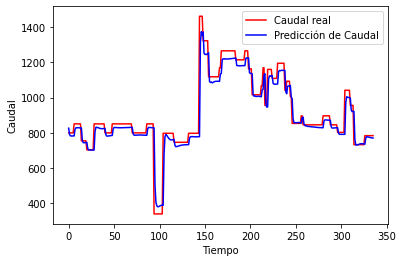

In [ ]:
plt.plot(datos_test.values[time_step:(time_step + 7*48)], color='red', label='Caudal real')
plt.plot(prediccion[:7*48], color='blue', label='Predicción de Caudal')
plt.xlabel('Tiempo')
plt.ylabel('Caudal')
plt.legend()
plt.show()

# Gráficos estadísticos

In [31]:
#Unión de datos 
datos_test_adj  = datos_test[time_step:].copy()
datos_test_pred = pd.concat([datos_test_adj, 
                  pd.DataFrame(prediccion, 
                               columns=['CAUDAL_PREDICT'], 
                               index = datos_test_adj.index)], 
                 axis =1)
datos_test_pred.head(20)

,CAUDAL,CAUDAL_PREDICT
FECHA,,
2019-04-02 11:00:00,799.3067,825.831360
2019-04-02 11:30:00,799.3067,789.539062
2019-04-02 12:00:00,799.3067,781.982483
2019-04-02 12:30:00,799.3067,781.806580
2019-04-02 13:00:00,799.3067,781.471436
2019-04-02 13:30:00,799.3067,781.693665
2019-04-02 14:00:00,850.4467,782.262817
2019-04-02 14:30:00,850.4467,820.004089
2019-04-02 15:00:00,850.4467,828.358643


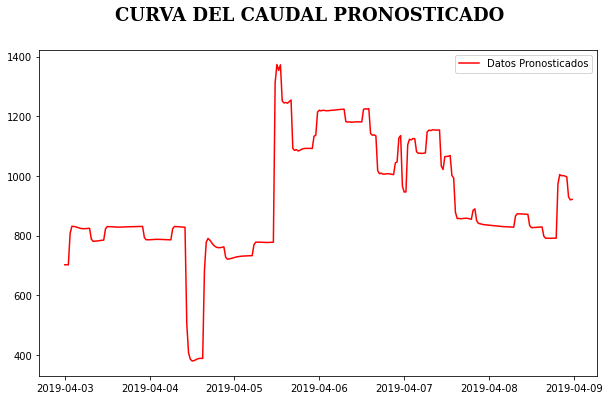

In [32]:
# Figura 5.8: Curva del caudal pronosticado
#Los primeros 7 dias(completos) de la prediccion (3 de abril)
semana_estudio_test_pred = datos_test_pred[
    datos_test_pred.index.get_loc('2019-04-03 00:00:00')[0]:
    datos_test_pred.index.get_loc('2019-04-09 00:00:00')[0]]

semana_estudio_test = semana_estudio_test_pred['CAUDAL']
semana_estudio_pred = semana_estudio_test_pred['CAUDAL_PREDICT']
plt.figure(figsize=(10,6))
plt.plot(semana_estudio_pred, 
           color='red', 
           label='Datos Pronosticados')
plt.suptitle('CURVA DEL CAUDAL PRONOSTICADO',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()

In [ ]:
# Tabla 5.2: Análisis descriptiva con datos reales del caudal
maximo = np.max(semana_estudio_pred)
print('Máximo = {}'.format(maximo))
minimo = np.min(semana_estudio_pred)
print('Mínimo = {}'.format(minimo))
rango = maximo - minimo
print('Rango = {}'.format(rango))
media = np.mean(semana_estudio_pred)
print('Media = {}'.format(media))
mediana = semana_estudio_pred.median()
print('Mediana = {}'.format(mediana))
varianza = semana_estudio_pred.var()
print('Varianza = {}'.format(varianza))
std = np.std(semana_estudio_pred)
print('Desviación Estándar = {}'.format(std))
coef_var = np.std(semana_estudio_pred) /np.mean(semana_estudio_pred) * 100
print('Coeficiente de variación = {} %'.format(coef_var))
lim_max = media + 1 * std
lim_min = media - 1 * std
print('Límite máximo = {}'.format(lim_max))
print('Límite mínimo = {}'.format(lim_min))

semana_estudio_pred.describe()

Máximo = 1373.87255859375
Mínimo = 379.4272155761719
Rango = 994.4453430175781
Media = 913.7523803710938
Mediana = 831.8135375976562
Varianza = 37904.2421875
Desviación Estándar = 194.35182189941406
Coeficiente de variación = 21.26963782250108 %
Límite máximo = 1108.1042022705078
Límite mínimo = 719.4005584716797


count     288.000000
mean      913.752380
std       194.690125
min       379.427216
25%       787.409637
50%       831.813538
75%      1084.098694
max      1373.872559
Name: CAUDAL_PREDICT, dtype: float64

In [ ]:
def funcionConstante(x, constante):
    return constante

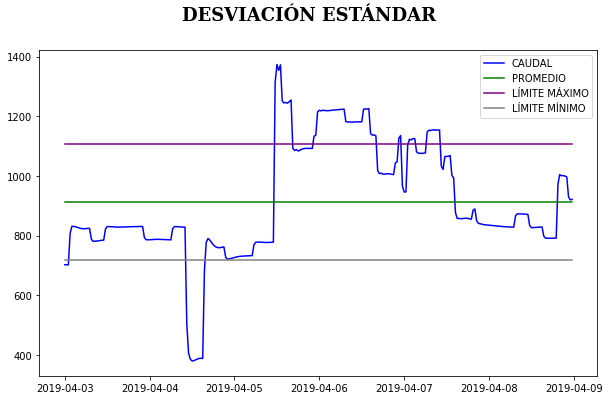

In [ ]:
# Figura 5.9: Desviación estándar con datos del caudal pronosticada

plt.figure(figsize=(10,6))
plt.plot(semana_estudio_pred.index,
         semana_estudio_pred, 
         color = 'blue', 
         label = 'CAUDAL')
plt.plot(semana_estudio_pred.index,
         [funcionConstante(x, media) for x in semana_estudio_pred], 
         color = 'green', 
         label = 'PROMEDIO')

plt.plot(semana_estudio_pred.index,
           [funcionConstante(x, lim_max) for x in semana_estudio_pred], 
           color = 'purple', 
           label = 'LÍMITE MÁXIMO')

plt.plot(semana_estudio_pred.index,
           [funcionConstante(x, lim_min) for x in semana_estudio_pred], 
           color = 'gray', 
           label = 'LÍMITE MÍNIMO')


plt.suptitle('DESVIACIÓN ESTÁNDAR',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()

In [ ]:
# Figura 5.10: Capacidades del proceso para el caudal (datos pronosticados - 1 semana)
#Exportacion de datos para sixpack capability system
semana_estudio_pred.to_csv('capabilities/prediccion_abril.csv')
semana_estudio_pred

FECHA
2019-04-03 00:00:00    702.208923
2019-04-03 00:30:00    702.182373
2019-04-03 01:00:00    701.942200
2019-04-03 01:30:00    807.044617
2019-04-03 02:00:00    831.083923
                          ...    
2019-04-08 21:30:00    999.517395
2019-04-08 22:00:00    996.801697
2019-04-08 22:30:00    929.523926
2019-04-08 23:00:00    919.796631
2019-04-08 23:30:00    921.377686
Name: CAUDAL_PREDICT, Length: 288, dtype: float32

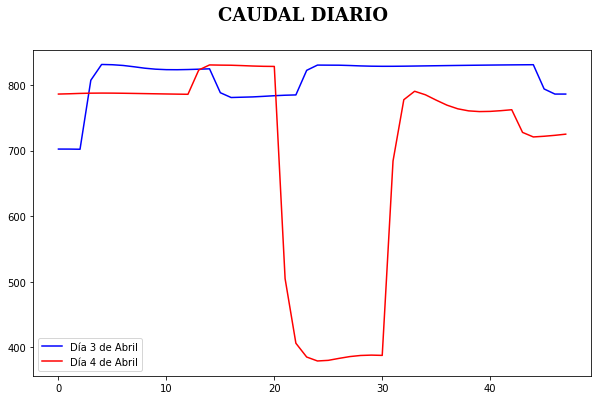

In [ ]:
# Figura 5.11: Caudal diario con datos obtenidos del pronostico
# Caudal vs Hora del dia 

tres_abril_predict = semana_estudio_pred[
    semana_estudio_pred.index.get_loc('2019-04-03 00:00:00'):
    semana_estudio_pred.index.get_loc('2019-04-04 00:00:00')]
cuatro_abril_predict = semana_estudio_pred[
    semana_estudio_pred.index.get_loc('2019-04-04 00:00:00'):
    semana_estudio_pred.index.get_loc('2019-04-05 00:00:00')]

serie = range(0,48)
plt.figure(figsize=(10,6))
plt.plot(serie,
         tres_abril_predict,
         color = 'blue', 
         label = 'Día 3 de Abril')

plt.plot(serie, 
            cuatro_abril_predict, 
            color = 'red', 
            label = 'Día 4 de Abril')

plt.suptitle('CAUDAL DIARIO',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()

In [ ]:
# Figura 5.12: Capacidades del proceso para el caudal (datos pronosticados - 1 día)
# exportamos los datos del dia 3 de abril 
tres_abril_predict.to_csv('capabilities/datos_tresAbril_pred.csv')
tres_abril_predict

FECHA
2019-04-03 00:00:00    702.208923
2019-04-03 00:30:00    702.182373
2019-04-03 01:00:00    701.942200
2019-04-03 01:30:00    807.044617
2019-04-03 02:00:00    831.083923
2019-04-03 02:30:00    830.676758
2019-04-03 03:00:00    829.548035
2019-04-03 03:30:00    827.578064
2019-04-03 04:00:00    825.404419
2019-04-03 04:30:00    823.900513
2019-04-03 05:00:00    823.177673
2019-04-03 05:30:00    823.073303
2019-04-03 06:00:00    823.372375
2019-04-03 06:30:00    823.878357
2019-04-03 07:00:00    824.458984
2019-04-03 07:30:00    788.057617
2019-04-03 08:00:00    780.745056
2019-04-03 08:30:00    781.205322
2019-04-03 09:00:00    781.658813
2019-04-03 09:30:00    782.517395
2019-04-03 10:00:00    783.486389
2019-04-03 10:30:00    784.227539
2019-04-03 11:00:00    784.692078
2019-04-03 11:30:00    822.131958
2019-04-03 12:00:00    830.140869
2019-04-03 12:30:00    830.037048
2019-04-03 13:00:00    829.967346
2019-04-03 13:30:00    829.489441
2019-04-03 14:00:00    828.868835
2019-04-

In [ ]:
tres_abril_predict.describe()

count     48.000000
mean     809.869934
std       33.628323
min      701.942200
25%      787.541275
50%      827.931702
75%      829.640320
max      831.083923
Name: CAUDAL_PREDICT, dtype: float64

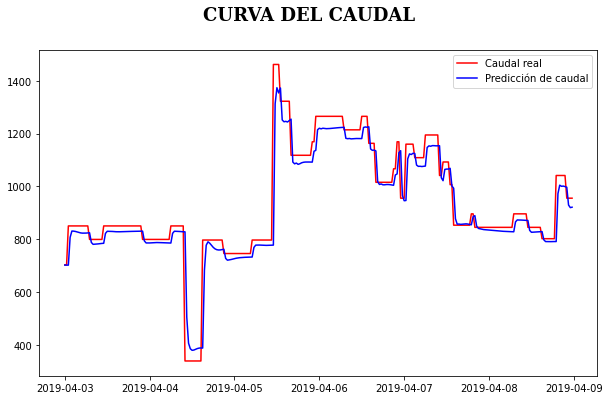

In [ ]:
# Figura 5.13: Curva del caudal real vs pronosticado
#Pronostico para los dias en estudio
plt.figure(figsize=(10,6))
plt.plot(semana_estudio_test, 
         color='red', 
         label='Caudal real')
plt.plot(semana_estudio_pred, 
         color='blue', 
         label='Predicción de caudal')
plt.suptitle('CURVA DEL CAUDAL',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()

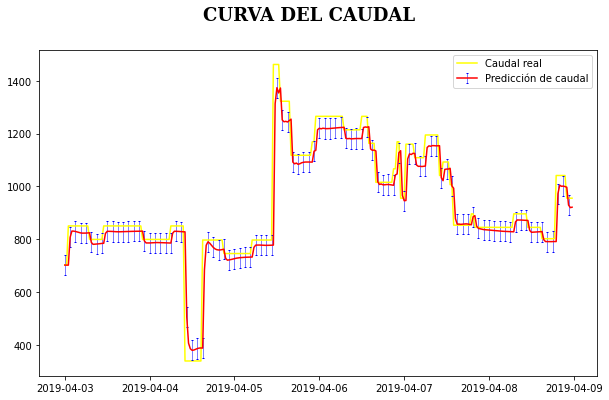

In [ ]:
#Figura 5.14: Gráfica de error entre curva del caudal real y pronosticado (semanal)

x = semana_estudio_test.index
y = semana_estudio_test

x_pred = x
y_pred = semana_estudio_pred

me =  (abs(y- y_pred)).mean(axis=0)
yerror = me
plt.figure(figsize=(10,6))
plt.plot(semana_estudio_test.index, 
         semana_estudio_test,
         color='yellow', 
         label='Caudal real')
plt.errorbar(x_pred,
         y_pred,
         yerr = yerror,
         ecolor = 'blue', 
         elinewidth = 0.5,
         capsize = 1,
         errorevery = 3,
         color='red', 
         label='Predicción de caudal')
plt.suptitle('CURVA DEL CAUDAL',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()

0      00:00:00
1      00:30:00
2      01:00:00
3      01:30:00
4      02:00:00
         ...   
283    21:30:00
284    22:00:00
285    22:30:00
286    23:00:00
287    23:30:00
Name: HORA, Length: 288, dtype: object


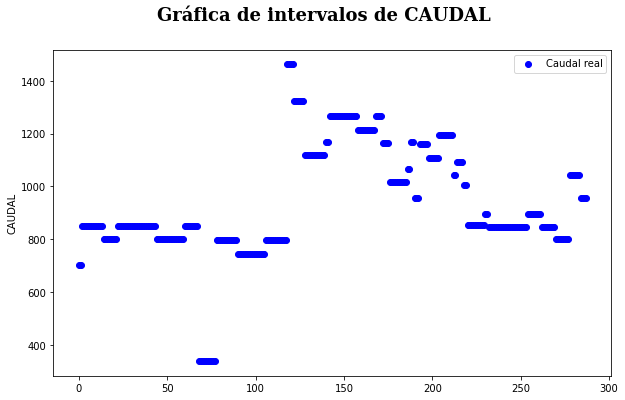

In [ ]:
# Figura 5.15: Intervalos del caudal (Datos reales y de pronóstico – 1 semana)

data_pred_test_hora = semana_estudio_test_pred.copy()
horas = datos['HORA'].iloc[:data_pred_test_hora['CAUDAL_PREDICT'].size]
print(horas)
horas_df = pd.DataFrame(horas, columns=['HORA'])
caudal_real_df = pd.DataFrame(data_pred_test_hora['CAUDAL'].values, columns=['CAUDAL'] )
caudal_real_df
data_pred_test_hora = pd.concat([caudal_real_df, 
                  horas_df], 
                 axis =1)
# data_pred_test_hora.set_index('HORA', drop=True, inplace= True)
data_pred_test_hora



plt.figure(figsize=(10,6))
plt.scatter(data_pred_test_hora.index,
               data_pred_test_hora['CAUDAL'], 
               color='blue', 
               label='Caudal real')

plt.suptitle('Gráfica de intervalos de CAUDAL',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.ylabel('CAUDAL')
plt.legend()
plt.show()

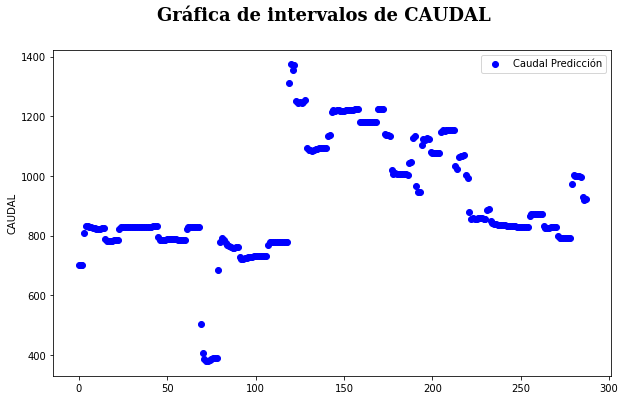

In [ ]:
caudal_pred_df = pd.DataFrame(semana_estudio_test_pred['CAUDAL_PREDICT'].values, columns=['CAUDAL_PREDICT'] )
caudal_pred_df
data_pred_test_hora = pd.concat([caudal_pred_df, 
                  horas_df], 
                 axis =1)

plt.figure(figsize=(10,6))
plt.scatter(data_pred_test_hora.index,
               data_pred_test_hora['CAUDAL_PREDICT'], 
               color='blue', 
               label='Caudal Predicción')

plt.suptitle('Gráfica de intervalos de CAUDAL',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.ylabel('CAUDAL')
plt.legend()
plt.show()

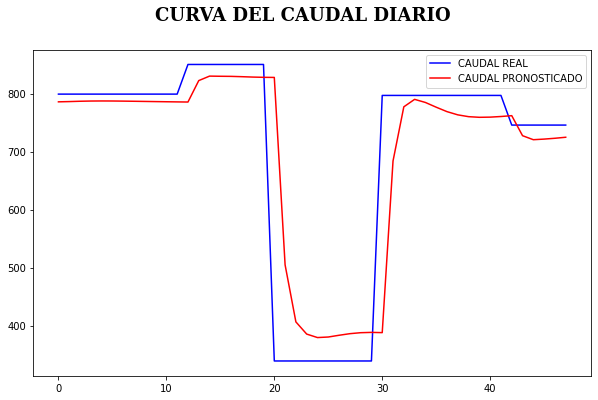

In [ ]:
# Figura 5.16: Curva caudal real vs pronosticado (Diario)
dia_abril_pred = semana_estudio_pred[
    semana_estudio_pred.index.get_loc('2019-04-04 00:00:00'):
    semana_estudio_pred.index.get_loc('2019-04-05 00:00:00')]

dia_abril_test = semana_estudio_test[
    semana_estudio_test.index.get_loc('2019-04-04 00:00:00'):
    semana_estudio_test.index.get_loc('2019-04-05 00:00:00')]
serie = range(0,48)
plt.figure(figsize=(10,6))
plt.plot(serie,
         dia_abril_test,
         color = 'blue', 
         label = 'CAUDAL REAL')

plt.plot(serie, 
         dia_abril_pred, 
         color = 'red', 
         label = 'CAUDAL PRONOSTICADO')

plt.suptitle('CURVA DEL CAUDAL DIARIO',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()

48.48843738911945


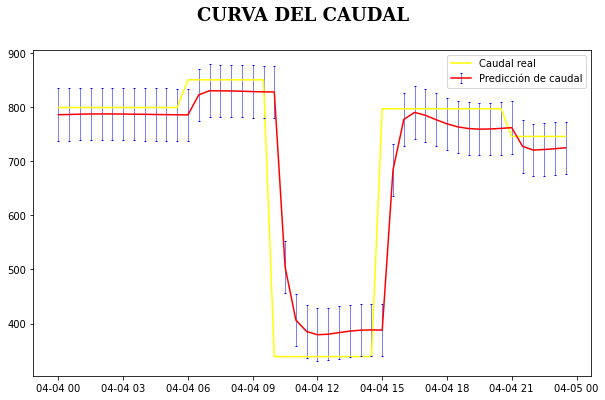

In [ ]:
# Figura 5.17: Grafica de error entre curva del caudal real y pronosticado (Diario)
x = dia_abril_test.index
y = dia_abril_test

x_pred = x
y_pred = dia_abril_pred

me =  (abs(y- y_pred)).mean(axis=0) 
print(me)
yerror = me
plt.figure(figsize=(10,6))
plt.plot(x, 
         y,
         color='yellow', 
         label='Caudal real')
plt.errorbar(x_pred,
         y_pred,
         yerr = yerror,
         ecolor = 'blue', 
         elinewidth = 0.5,
         capsize = 1,
         color='red', 
         label='Predicción de caudal')
plt.suptitle('CURVA DEL CAUDAL',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()

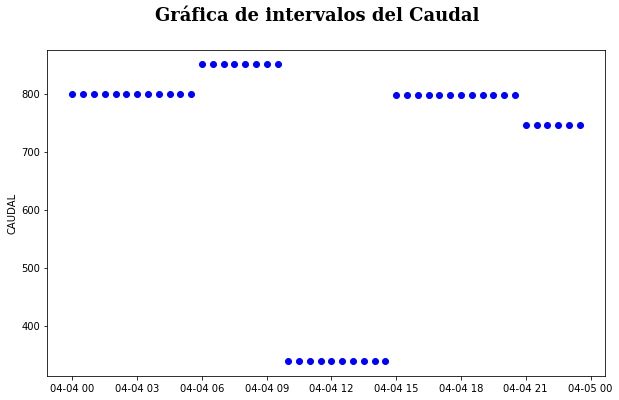

In [ ]:
# Figura 5.18: Intervalos del caudal (Datos reales y de pronóstico - 1dia)
plt.figure(figsize=(10,6))
plt.scatter(x,
            y, 
            color='blue', 
            label='Caudal real')

plt.suptitle('Gráfica de intervalos del Caudal',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.ylabel('CAUDAL')
plt.show()

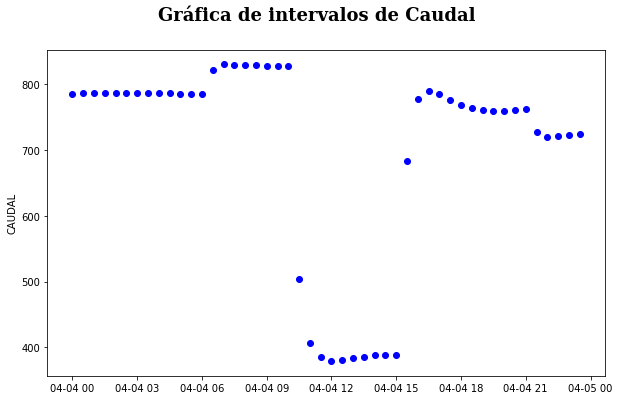

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(x_pred,
            y_pred, 
            color='blue', 
            label='Caudal pronosticado')

plt.suptitle('Gráfica de intervalos de Caudal',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.ylabel('CAUDAL')
plt.show()

# Análisis Hiperparámetros

## Algoritmo de optimización

### ADAM

In [ ]:
model_adam, history_adam= MODEL_LSTM(optimizador = 'adam', neuronas = 10, epocas = 10)
model_adam.save('modelos/model_adam.h5')

Epoch 1/10
1071/1071 [==============================] - 82s 72ms/step - loss: 0.0238 - mean_absolute_error: 0.1119
Epoch 2/10
1071/1071 [==============================] - 74s 69ms/step - loss: 0.0087 - mean_absolute_error: 0.0691
Epoch 3/10
1071/1071 [==============================] - 84s 78ms/step - loss: 0.0049 - mean_absolute_error: 0.0496
Epoch 4/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0037 - mean_absolute_error: 0.0412
Epoch 5/10
1071/1071 [==============================] - 63s 59ms/step - loss: 0.0031 - mean_absolute_error: 0.0372
Epoch 6/10
1071/1071 [==============================] - 64s 59ms/step - loss: 0.0028 - mean_absolute_error: 0.0352
Epoch 7/10
1071/1071 [==============================] - 64s 59ms/step - loss: 0.0026 - mean_absolute_error: 0.0338
Epoch 8/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0026 - mean_absolute_error: 0.0332
Epoch 9/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.

In [ ]:
model_adam = keras.models.load_model('modelos/model_adam.h5')
prediccion_adam = predecirDataTest(model_adam)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### ADADELTA

In [ ]:
model_adadelta, history_adadelta = MODEL_LSTM(optimizador = 'adadelta', neuronas = 10, epocas = 10)
model_adadelta.save('modelos/model_adadelta.h5')

Epoch 1/10
1071/1071 [==============================] - 78s 64ms/step - loss: 0.4605 - mean_absolute_error: 0.6484
Epoch 2/10
1071/1071 [==============================] - 65s 61ms/step - loss: 0.4046 - mean_absolute_error: 0.6059
Epoch 3/10
1071/1071 [==============================] - 63s 59ms/step - loss: 0.3347 - mean_absolute_error: 0.5475
Epoch 4/10
1071/1071 [==============================] - 63s 58ms/step - loss: 0.2483 - mean_absolute_error: 0.4638
Epoch 5/10
1071/1071 [==============================] - 63s 59ms/step - loss: 0.1488 - mean_absolute_error: 0.3402
Epoch 6/10
1071/1071 [==============================] - 63s 59ms/step - loss: 0.0780 - mean_absolute_error: 0.2259
Epoch 7/10
1071/1071 [==============================] - 63s 59ms/step - loss: 0.0567 - mean_absolute_error: 0.1889
Epoch 8/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.0519 - mean_absolute_error: 0.1809
Epoch 9/10
1071/1071 [==============================] - 63s 58ms/step - loss: 0.

In [ ]:
model_adadelta = keras.models.load_model('modelos/model_adadelta.h5')
prediccion_adadelta = predecirDataTest(model_adadelta)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### RMSPROP

In [ ]:
model_rmsprop, history_rmsprop = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 10, epocas = 10)
model_rmsprop.save('modelos/model_rmsprop.h5')

Epoch 1/10
1071/1071 [==============================] - 68s 59ms/step - loss: 0.0152 - mean_absolute_error: 0.0856
Epoch 2/10
1071/1071 [==============================] - 64s 59ms/step - loss: 0.0039 - mean_absolute_error: 0.0432
Epoch 3/10
1071/1071 [==============================] - 63s 59ms/step - loss: 0.0029 - mean_absolute_error: 0.0360
Epoch 4/10
1071/1071 [==============================] - 63s 59ms/step - loss: 0.0027 - mean_absolute_error: 0.0344
Epoch 5/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0026 - mean_absolute_error: 0.0336
Epoch 6/10
1071/1071 [==============================] - 64s 59ms/step - loss: 0.0026 - mean_absolute_error: 0.0334
Epoch 7/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0025 - mean_absolute_error: 0.0329
Epoch 8/10
1071/1071 [==============================] - 63s 59ms/step - loss: 0.0025 - mean_absolute_error: 0.0329
Epoch 9/10
1071/1071 [==============================] - 64s 59ms/step - loss: 0.

In [ ]:
model_rmsprop = keras.models.load_model('modelos/model_rmsprop.h5')
prediccion_rmsprop = predecirDataTest(model_rmsprop)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### Comparación de Optimizadores 

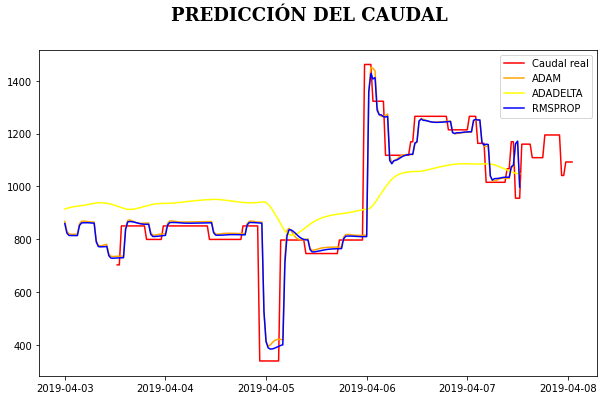

218


In [ ]:
#Figura 5.42: Resultados variación algoritmo de entrenamiento de la red neuronal

plt.figure(figsize=(10,6))

limite = len(semana_estudio_test) -70
plt.plot(semana_estudio_test.index[25:limite+25],
         semana_estudio_test[:limite], 
         color='red', 
         label='Caudal real')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_adam[:limite], 
         color='orange', 
         label='ADAM')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_adadelta[:limite], 
         color='yellow', 
         label='ADADELTA')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_rmsprop[:limite], 
         color='blue', 
         label='RMSPROP')

plt.suptitle('PREDICCIÓN DEL CAUDAL',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()
print(limite)

## Número de neuronas 

### 1 Neurona 

In [ ]:
model_unaN, history_unaN = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 1, epocas = 10)
model_unaN.save('modelos/model_unaN.h5')

Epoch 1/10
1071/1071 [==============================] - 78s 68ms/step - loss: 0.0591 - mean_absolute_error: 0.1647
Epoch 2/10
1071/1071 [==============================] - 73s 68ms/step - loss: 0.0126 - mean_absolute_error: 0.0764
Epoch 3/10
1071/1071 [==============================] - 65s 60ms/step - loss: 0.0118 - mean_absolute_error: 0.0724
Epoch 4/10
1071/1071 [==============================] - 59s 55ms/step - loss: 0.0116 - mean_absolute_error: 0.0712
Epoch 5/10
1071/1071 [==============================] - 54s 50ms/step - loss: 0.0113 - mean_absolute_error: 0.0701
Epoch 6/10
1071/1071 [==============================] - 52s 48ms/step - loss: 0.0114 - mean_absolute_error: 0.0703
Epoch 7/10
1071/1071 [==============================] - 53s 49ms/step - loss: 0.0116 - mean_absolute_error: 0.0703
Epoch 8/10
1071/1071 [==============================] - 52s 49ms/step - loss: 0.0114 - mean_absolute_error: 0.0702
Epoch 9/10
1071/1071 [==============================] - 57s 53ms/step - loss: 0.

In [ ]:
model_unaN = keras.models.load_model('modelos/model_unaN.h5')
# model_unaN.summary()
prediccion_unaN = predecirDataTest(model_unaN)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### 3 Neuronas

In [ ]:
model_tresN, history_tresN = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 3, epocas = 10)
model_tresN.save('modelos/model_tresN.h5')

Epoch 1/10
1071/1071 [==============================] - 72s 58ms/step - loss: 0.0473 - mean_absolute_error: 0.1373
Epoch 2/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.0066 - mean_absolute_error: 0.0567
Epoch 3/10
1071/1071 [==============================] - 60s 56ms/step - loss: 0.0057 - mean_absolute_error: 0.0522
Epoch 4/10
1071/1071 [==============================] - 60s 56ms/step - loss: 0.0055 - mean_absolute_error: 0.0510
Epoch 5/10
1071/1071 [==============================] - 60s 56ms/step - loss: 0.0054 - mean_absolute_error: 0.0502
Epoch 6/10
1071/1071 [==============================] - 59s 56ms/step - loss: 0.0052 - mean_absolute_error: 0.0498
Epoch 7/10
1071/1071 [==============================] - 60s 56ms/step - loss: 0.0052 - mean_absolute_error: 0.0497
Epoch 8/10
1071/1071 [==============================] - 59s 56ms/step - loss: 0.0051 - mean_absolute_error: 0.0491
Epoch 9/10
1071/1071 [==============================] - 60s 56ms/step - loss: 0.

In [ ]:
model_tresN = keras.models.load_model('modelos/model_tresN.h5')
# model_tresN.summary()
prediccion_tresN = predecirDataTest(model_tresN)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### 5 Neuronas

In [ ]:
model_cincoN, history_cincoN = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 5, epocas = 10)
model_cincoN.save('modelos/model_cincoN.h5')

Epoch 1/10
1071/1071 [==============================] - 67s 58ms/step - loss: 0.0191 - mean_absolute_error: 0.0966
Epoch 2/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.0052 - mean_absolute_error: 0.0510
Epoch 3/10
1071/1071 [==============================] - 62s 57ms/step - loss: 0.0043 - mean_absolute_error: 0.0447
Epoch 4/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.0040 - mean_absolute_error: 0.0430
Epoch 5/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.0039 - mean_absolute_error: 0.0424
Epoch 6/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.0038 - mean_absolute_error: 0.0419
Epoch 7/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.0038 - mean_absolute_error: 0.0415
Epoch 8/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.0037 - mean_absolute_error: 0.0411
Epoch 9/10
1071/1071 [==============================] - 62s 58ms/step - loss: 0.

In [ ]:
model_cincoN = keras.models.load_model('modelos/model_cincoN.h5')
# model_cincoN.summary()
prediccion_cincoN = predecirDataTest(model_cincoN)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### 10 Neuronas

In [ ]:
model_diezN, history_diezN = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 10, epocas = 10)
model_diezN.save('modelos/model_diezN.h5')

Epoch 1/10
1071/1071 [==============================] - 68s 60ms/step - loss: 0.0160 - mean_absolute_error: 0.0880
Epoch 2/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0039 - mean_absolute_error: 0.0434
Epoch 3/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0030 - mean_absolute_error: 0.0367
Epoch 4/10
1071/1071 [==============================] - 64s 59ms/step - loss: 0.0027 - mean_absolute_error: 0.0344
Epoch 5/10
1071/1071 [==============================] - 64s 59ms/step - loss: 0.0026 - mean_absolute_error: 0.0335
Epoch 6/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0025 - mean_absolute_error: 0.0330
Epoch 7/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0025 - mean_absolute_error: 0.0326
Epoch 8/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0024 - mean_absolute_error: 0.0322
Epoch 9/10
1071/1071 [==============================] - 64s 60ms/step - loss: 0.

In [ ]:
model_diezN = keras.models.load_model('modelos/model_diezN.h5')
# model_diezN.summary()
prediccion_diezN = predecirDataTest(model_diezN)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### 15 Neuronas

In [ ]:
model_quinceN, history_quinceN = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 15, epocas = 10)
model_quinceN.save('modelos/model_quinceN.h5')

Epoch 1/10
1071/1071 [==============================] - 71s 62ms/step - loss: 0.0126 - mean_absolute_error: 0.0812
Epoch 2/10
1071/1071 [==============================] - 67s 62ms/step - loss: 0.0040 - mean_absolute_error: 0.0448
Epoch 3/10
1071/1071 [==============================] - 67s 62ms/step - loss: 0.0026 - mean_absolute_error: 0.0343
Epoch 4/10
1071/1071 [==============================] - 66s 62ms/step - loss: 0.0023 - mean_absolute_error: 0.0318
Epoch 5/10
1071/1071 [==============================] - 66s 62ms/step - loss: 0.0022 - mean_absolute_error: 0.0309
Epoch 6/10
1071/1071 [==============================] - 69s 64ms/step - loss: 0.0022 - mean_absolute_error: 0.0303
Epoch 7/10
1071/1071 [==============================] - 67s 63ms/step - loss: 0.0022 - mean_absolute_error: 0.0300
Epoch 8/10
1071/1071 [==============================] - 67s 62ms/step - loss: 0.0021 - mean_absolute_error: 0.0297
Epoch 9/10
1071/1071 [==============================] - 67s 63ms/step - loss: 0.

In [ ]:
model_quinceN = keras.models.load_model('modelos/model_quinceN.h5')
# model_quinceN.summary()
prediccion_quinceN = predecirDataTest(model_quinceN)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### Gráfica Comparación Neuronas 

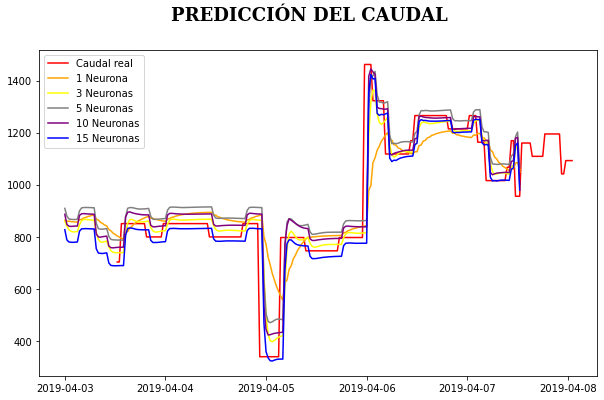

In [ ]:
# Figura 5.43: Resultados variación número de neuronas

plt.figure(figsize=(10,6))

plt.plot(semana_estudio_test.index[25:limite+25],
         semana_estudio_test[:limite], 
         color='red', 
         label='Caudal real')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_unaN[:limite], 
         color='orange', 
         label='1 Neurona')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_tresN[:limite], 
         color='yellow', 
         label='3 Neuronas')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_cincoN[:limite], 
         color='gray', 
         label='5 Neuronas')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_diezN[:limite], 
         color='purple', 
         label='10 Neuronas')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_quinceN[:limite], 
         color='blue', 
         label='15 Neuronas')

plt.suptitle('PREDICCIÓN DEL CAUDAL',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()

## Análisis de épocas 

### 3 épocas 

In [17]:
model_tresE, history_quinceN = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 15, epocas = 3)
model_tresE.save('modelos/model_tresE.h5')

Epoch 1/3
1071/1071 [==============================] - 81s 71ms/step - loss: 0.0117 - mean_absolute_error: 0.0784
Epoch 2/3
1071/1071 [==============================] - 66s 61ms/step - loss: 0.0038 - mean_absolute_error: 0.0430
Epoch 3/3
1071/1071 [==============================] - 64s 60ms/step - loss: 0.0026 - mean_absolute_error: 0.0337


In [18]:
model_tresE = keras.models.load_model('modelos/model_tresE.h5')
prediccion_tresE = predecirDataTest(model_tresE)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### 5 épocas 

In [19]:
model_cincoE, history_quinceN = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 15, epocas = 5)
model_cincoE.save('modelos/model_cincoE.h5')

Epoch 1/5
1071/1071 [==============================] - 70s 62ms/step - loss: 0.0127 - mean_absolute_error: 0.0816
Epoch 2/5
1071/1071 [==============================] - 83s 78ms/step - loss: 0.0039 - mean_absolute_error: 0.0436
Epoch 3/5
1071/1071 [==============================] - 70s 65ms/step - loss: 0.0025 - mean_absolute_error: 0.0330
Epoch 4/5
1071/1071 [==============================] - 79s 74ms/step - loss: 0.0022 - mean_absolute_error: 0.0306
Epoch 5/5
1071/1071 [==============================] - 68s 64ms/step - loss: 0.0022 - mean_absolute_error: 0.0298


In [20]:
model_cincoE = keras.models.load_model('modelos/model_cincoE.h5')
prediccion_cincoE = predecirDataTest(model_cincoE)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### 10 épocas 

In [21]:
model_diezE, history_diezN = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 15, epocas = 10)
model_diezE.save('modelos/model_diezE.h5')

Epoch 1/10
1071/1071 [==============================] - 74s 65ms/step - loss: 0.0140 - mean_absolute_error: 0.0838
Epoch 2/10
1071/1071 [==============================] - 69s 65ms/step - loss: 0.0040 - mean_absolute_error: 0.0442
Epoch 3/10
1071/1071 [==============================] - 67s 62ms/step - loss: 0.0025 - mean_absolute_error: 0.0334
Epoch 4/10
1071/1071 [==============================] - 67s 63ms/step - loss: 0.0022 - mean_absolute_error: 0.0308
Epoch 5/10
1071/1071 [==============================] - 67s 63ms/step - loss: 0.0022 - mean_absolute_error: 0.0300
Epoch 6/10
1071/1071 [==============================] - 67s 62ms/step - loss: 0.0021 - mean_absolute_error: 0.0295
Epoch 7/10
1071/1071 [==============================] - 67s 63ms/step - loss: 0.0021 - mean_absolute_error: 0.0293
Epoch 8/10
1071/1071 [==============================] - 68s 63ms/step - loss: 0.0021 - mean_absolute_error: 0.0293
Epoch 9/10
1071/1071 [==============================] - 69s 65ms/step - loss: 0.

In [22]:
model_diezE = keras.models.load_model('modelos/model_diezE.h5')
prediccion_diezE = predecirDataTest(model_diezE)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### 15 épocas 

In [23]:
model_quinceE, history_quinceN = MODEL_LSTM(optimizador = 'rmsprop', neuronas = 15, epocas = 15)
model_quinceE.save('modelos/model_quinceE.h5')

Epoch 1/15
1071/1071 [==============================] - 71s 63ms/step - loss: 0.0160 - mean_absolute_error: 0.0854
Epoch 2/15
1071/1071 [==============================] - 71s 66ms/step - loss: 0.0038 - mean_absolute_error: 0.0432
Epoch 3/15
1071/1071 [==============================] - 77s 72ms/step - loss: 0.0026 - mean_absolute_error: 0.0337
Epoch 4/15
1071/1071 [==============================] - 74s 69ms/step - loss: 0.0023 - mean_absolute_error: 0.0310
Epoch 5/15
1071/1071 [==============================] - 70s 66ms/step - loss: 0.0022 - mean_absolute_error: 0.0303
Epoch 6/15
1071/1071 [==============================] - 72s 67ms/step - loss: 0.0022 - mean_absolute_error: 0.0297
Epoch 7/15
1071/1071 [==============================] - 69s 65ms/step - loss: 0.0021 - mean_absolute_error: 0.0293
Epoch 8/15
1071/1071 [==============================] - 69s 65ms/step - loss: 0.0021 - mean_absolute_error: 0.0291
Epoch 9/15
1071/1071 [==============================] - 67s 62ms/step - loss: 0.

In [24]:
model_quinceE = keras.models.load_model('modelos/model_quinceE.h5')
prediccion_quinceE = predecirDataTest(model_quinceE)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### Gráfica comparativa 

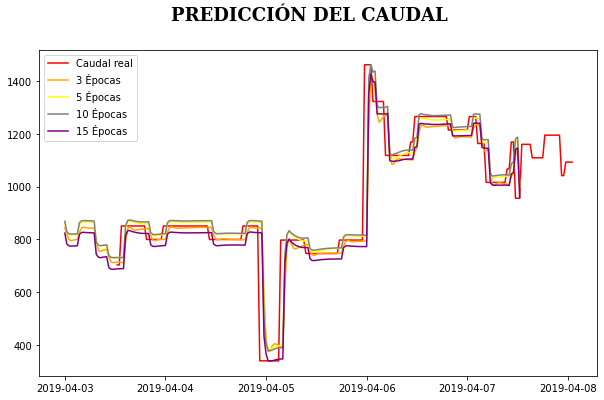

In [51]:
#Figura 5.44: Resultados variación número de epocas

plt.figure(figsize=(10,6))

limite = len(semana_estudio_test)-70

plt.plot(semana_estudio_test.index[25:limite+25],
         semana_estudio_test[:limite], 
         color='red', 
         label='Caudal real')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_tresE[:limite], 
         color='orange', 
         label='3 Épocas')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_cincoE[:limite], 
         color='yellow', 
         label='5 Épocas')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_diezE[:limite], 
         color='gray', 
         label='10 Épocas')
plt.plot(semana_estudio_test.index[:limite],
         prediccion_quinceE[:limite], 
         color='purple', 
         label='15 Épocas')


plt.suptitle('PREDICCIÓN DEL CAUDAL',
            fontsize = 18,
            fontweight = 'bold',
            fontfamily='serif')
plt.legend()
plt.show()